In [1]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import spacy

import transformer_lens
from probe_model import LinearProbe, Trainer, TrainerConfig

## Setup

In [2]:
device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda" # CUDA for NVIDIA GPU

device = torch.device(device_name)
print(f"Device: {device_name}")

Device: cuda


In [3]:
# Loading pretrained model from transformer_lens

model_name = "gpt2-small"
# model_name = "gpt2-medium"
model = transformer_lens.HookedTransformer.from_pretrained(model_name)

HIDDEN_DIM = model.cfg.d_model

Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
# Load the spaCy model
spacy_model = spacy.load("en_core_web_sm")

## Generate dataset

### Load text

In [5]:
# corpus = 'datasets/prewar.txt'
corpus = 'datasets/brown.dev'
with open(corpus, 'r') as f:
    raw_sentences = [line.rstrip("\n") for line in f.readlines()]

DATASET_CUTOFF = 10000
raw_sentences = raw_sentences[:DATASET_CUTOFF]
np.random.choice(raw_sentences, 5)

array(["Mike kept walking and got within arm's reach before the man became suspicious and straightened from his lax slouch .",
       'He scuttled in shadow along the east wall of the stockade and then followed the south wall until he was at the rear of the two frame buildings .',
       'He ceased weeping .', 'Autos whizzed past .',
       'The coyote was calling again , and he hoped that this time there would be no other sounds to interrupt it .'],
      dtype='<U754')

### Generating text sequences with labels (word index)

In [6]:
def map_word_index(text, prepend_bos=False):
    gpt_tokens = model.to_tokens(text, prepend_bos=prepend_bos).squeeze(0)
    gpt_tokens_str = [model.to_single_str_token(int(t)) for t in gpt_tokens]

    doc = spacy_model(str(text))
    word_idxs = [t.text for t in doc if t.is_alpha]

    if not len(word_idxs):
        return torch.Tensor(), []

    i = 0
    cur = 0 # current word index
    sub_idx = 0 # sub index of current word

    result = []
    while i < len(gpt_tokens_str):
        t = gpt_tokens_str[i].strip()
        # skip if token is just a newline or other whitespace
        if not len(t):
            result.append((t, i, -1))
            i += 1
            continue

        cur_word = word_idxs[cur]
        # if token is part of current word, update sub_idx, continue to next token
        if cur_word.find(t, sub_idx) != -1:
            result.append((t, i, cur))
            sub_idx += len(t)
            i += 1
        else:
            # if token not in cur_word, check next word
            if cur+1 < len(word_idxs) and t in word_idxs[cur+1]:
                cur += 1
                sub_idx = 0
            # if not in cur_word or next word, give up and continue
            else:
                result.append((t, i, -1))
                i += 1 

    return gpt_tokens, result

In [7]:
# check that map_word_index function is working correctly
# for s in tqdm(raw_sentences):
#     tokens, info = map_word_index(s)
#     assert len(tokens) == len(info)

In [8]:
SEQ_LEN = 500

def generate_seq():
    tokens = model.to_tokens("\n", prepend_bos=True).squeeze(0)
    info = [("\n", 0, -1)]

    while len(tokens) < SEQ_LEN:
        next_t, next_info = map_word_index(np.random.choice(raw_sentences))
        if len(next_t):
            tokens = torch.cat((tokens, next_t))
            info.extend(next_info)

    word_idx = np.array(list(map(lambda x: x[2], info)))
    return tokens, word_idx

tokens, word_idx = generate_seq()
np.unique(word_idx, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 array([101,  40,  34,  34,  30,  32,  32,  27,  18,  18,  16,  15,  16,
         15,  14,  10,  10,  10,   9,   4,   5,   4,   3,   2,   2,   2,
          2,   1,   1,   1]))

### Generate Embeddings

In [9]:
N_SEQS = 100
# cutoff initial tokens because model behavior is weird there
PREFIX_CUTOFF = 50

torch.set_grad_enabled(False)

all_resids = []
all_word_idx = []

for i_batch in tqdm(range(N_SEQS)):
    tokens, word_idx = generate_seq()
    # make sure tokens don't exceed GPT2's context length
    tokens = tokens[:1000]

    _, cache = model.run_with_cache(tokens, names_filter=lambda x: x.endswith("resid_post"))
    residuals = cache.stack_activation("resid_post")

    # residuals.shape = (layer, batch, seq_len, model_residual_dimension)
    residuals = residuals[:, 0, PREFIX_CUTOFF+1:, :]
    word_idx = word_idx[PREFIX_CUTOFF:]

    assert residuals.shape[1] == word_idx.shape[0]

    # this mask excludes puncuation and word fragments
    mask = word_idx != -1

    all_resids.append(residuals.cpu().numpy()[:, mask])
    all_word_idx.append(word_idx[mask])



100%|██████████| 100/100 [00:29<00:00,  3.43it/s]


In [10]:
x_all_layers = np.concatenate(all_resids, axis=1)
y_all = np.concatenate(all_word_idx)

print(x_all_layers.shape)
print(y_all.shape)

(12, 36869, 768)
(36869,)


In [11]:
N_BUCKETS = 5
percentile_buckets = [(100 // N_BUCKETS) * i for i in range(1, N_BUCKETS)]
cutoffs = np.percentile(y_all, percentile_buckets)
q_binned = np.searchsorted(cutoffs, y_all, side='right')

assert len(cutoffs) == len(set(cutoffs)), "too many buckets, not all cutoffs are unique"

print(cutoffs)

[ 2.  5.  9. 15.]


### filter data

In [12]:
LAYER = 2

X = x_all_layers[LAYER, :]
Y = q_binned

print(X.shape)
print(Y.shape)

(36869, 768)
(36869,)


## Training Probes

In [13]:
class ProbingDataset(Dataset):
    def __init__(self, act, y):
        assert len(act) == len(y)
        print(f"dataset: {len(act)} pairs loaded...")
        self.act = act
        self.y = y
        print("y:", np.unique(y, return_counts=True))
        
    def __len__(self, ):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.tensor(self.act[idx]), torch.tensor(self.y[idx]).long()

In [14]:
probing_dataset = ProbingDataset(X, Y)
train_size = int(0.8 * len(probing_dataset))
test_size = len(probing_dataset) - train_size
probe_train_dataset, probe_test_dataset = torch.utils.data.random_split(probing_dataset, [train_size, test_size])
print(f"split into [test/train], [{test_size}/{train_size}]")

dataset: 36869 pairs loaded...
y: (array([0, 1, 2, 3, 4]), array([5900, 7469, 7837, 7636, 8027]))
split into [test/train], [7374/29495]


In [15]:
probe = LinearProbe(device, HIDDEN_DIM, len(np.unique(Y)))

EXPERIMENT_NAME = f"brown_{N_BUCKETS}qbin_366k"
folder = f"ckpts/{model_name}/{EXPERIMENT_NAME}/layer{LAYER}"
if os.path.isdir(folder):
    print(f"Warning, {folder} already exists")
config = TrainerConfig(num_epochs=20, ckpt_path=folder)
trainer = Trainer(device, probe, probe_train_dataset, probe_test_dataset, config)

Warning, ckpts/gpt2-small/brown_5qbin_366k/layer2 already exists


In [16]:
trainer.train()

Epoch 1; Train Loss: 1.45616; Train Acc: 45.408%; Test Acc: 58.842%:   5%|▌         | 1/20 [00:00<00:10,  1.84it/s]

Epoch 20; Train Loss: 0.47693; Train Acc: 80.573%; Test Acc: 77.963%: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


In [17]:
print(trainer.generate_report())

              precision    recall  f1-score   support

           0     0.9592    0.9262    0.9424      1219
           1     0.7919    0.8426    0.8165      1436
           2     0.7062    0.7004    0.7033      1599
           3     0.6700    0.6486    0.6591      1571
           4     0.8137    0.8205    0.8171      1549

    accuracy                         0.7796      7374
   macro avg     0.7882    0.7877    0.7877      7374
weighted avg     0.7796    0.7796    0.7794      7374



### plotting loss curves

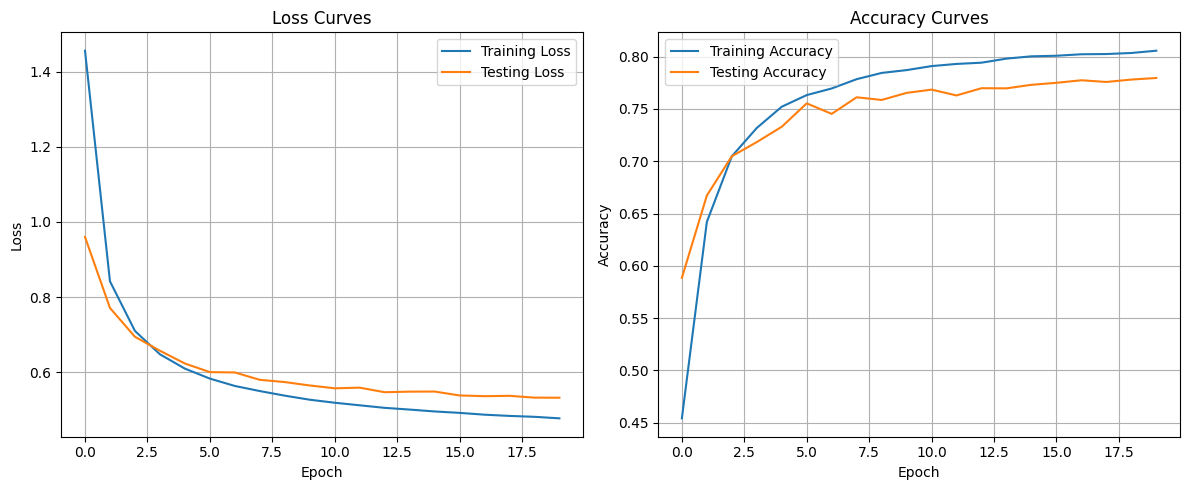

In [18]:
metrics_path = os.path.join(folder, 'metrics.json')

# Load the metrics from the JSON file
with open(metrics_path, 'r') as f:
    metrics = json.load(f)['metrics']

# Extract the loss and accuracy data
train_loss = metrics['train_loss']
test_loss = metrics['test_loss']
train_acc = metrics['train_acc']
test_acc = metrics['test_acc']

# Plot the loss curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### training on all layers

In [59]:
for LAYER in range(x_all_layers.shape[0]):
    print(f"LAYER: {LAYER}")
    X = x_all_layers[LAYER, :]

    probing_dataset = ProbingDataset(X, Y)
    train_size = int(0.8 * len(probing_dataset))
    test_size = len(probing_dataset) - train_size
    probe_train_dataset, probe_test_dataset = torch.utils.data.random_split(probing_dataset, [train_size, test_size])

    probe = LinearProbe(device, HIDDEN_DIM, len(np.unique(Y)))

    EXPERIMENT_NAME = f"prewar_{N_BUCKETS}qbin_425k"
    folder = f"ckpts/{model_name}/{EXPERIMENT_NAME}/layer{LAYER}"
    if os.path.isdir(folder):
        print(f"Warning, {folder} already exists")
    config = TrainerConfig(num_epochs=20, ckpt_path=folder)
    trainer = Trainer(device, probe, probe_train_dataset, probe_test_dataset, config)

    trainer.train()

LAYER: 0
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.83952; Train Acc: 30.759%; Test Acc: 30.706%: 100%|██████████| 20/20 [02:03<00:00,  6.18s/it]


LAYER: 1
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.50658; Train Acc: 40.624%; Test Acc: 39.540%: 100%|██████████| 20/20 [02:03<00:00,  6.19s/it]


LAYER: 2
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.36533; Train Acc: 44.917%; Test Acc: 44.711%: 100%|██████████| 20/20 [02:04<00:00,  6.25s/it]


LAYER: 3
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.37073; Train Acc: 44.926%; Test Acc: 44.669%: 100%|██████████| 20/20 [02:04<00:00,  6.20s/it]


LAYER: 4
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.33381; Train Acc: 45.876%; Test Acc: 45.453%: 100%|██████████| 20/20 [02:03<00:00,  6.16s/it]


LAYER: 5
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.30361; Train Acc: 46.558%; Test Acc: 46.863%: 100%|██████████| 20/20 [02:04<00:00,  6.24s/it]


LAYER: 6
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.31576; Train Acc: 46.171%; Test Acc: 45.631%: 100%|██████████| 20/20 [02:05<00:00,  6.25s/it]


LAYER: 7
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.36286; Train Acc: 44.384%; Test Acc: 44.286%: 100%|██████████| 20/20 [02:04<00:00,  6.23s/it]


LAYER: 8
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.46010; Train Acc: 41.489%; Test Acc: 41.067%: 100%|██████████| 20/20 [02:03<00:00,  6.19s/it]


LAYER: 9
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.58281; Train Acc: 37.902%; Test Acc: 37.037%: 100%|██████████| 20/20 [02:04<00:00,  6.20s/it]


LAYER: 10
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.70084; Train Acc: 34.789%; Test Acc: 34.483%: 100%|██████████| 20/20 [02:04<00:00,  6.24s/it]


LAYER: 11
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.84143; Train Acc: 31.609%; Test Acc: 32.026%: 100%|██████████| 20/20 [02:03<00:00,  6.20s/it]


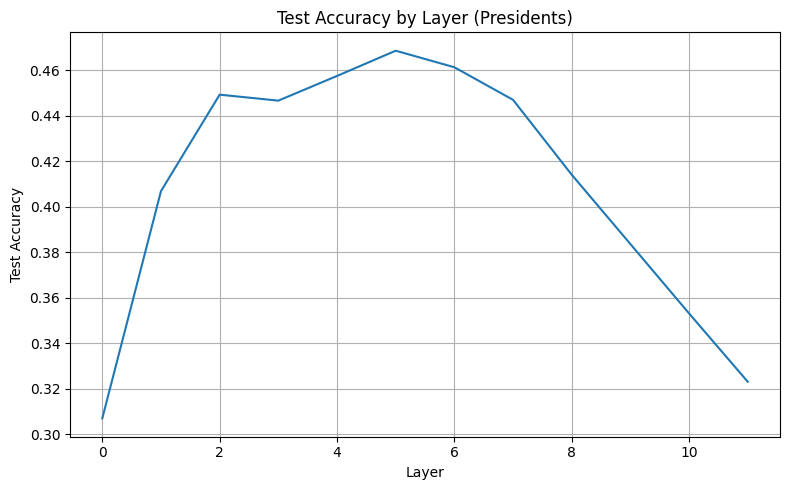

In [62]:
by_layer = []
for i in range(12):
    with open(f"ckpts/{model_name}/{EXPERIMENT_NAME}/layer{i}/metrics.json", 'r') as f:
        metrics = json.load(f)['metrics']
        best = max(metrics['test_acc'])
        by_layer.append(best)

plt.figure(figsize=(8, 5))

plt.plot(by_layer)
plt.title('Test Accuracy by Layer (Presidents)')
plt.xlabel('Layer')
plt.ylabel('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()